# Импорт библиотек и модулей 

In [3]:
#первая предобученая модель
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz
!gunzip cc.ru.300.bin.gz

--2020-12-24 16:08:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4496459151 (4.2G) [application/octet-stream]
Saving to: ‘cc.ru.300.bin.gz’

cc.ru.300.bin.gz    100%[===================>]   4.19G  27.7MB/s    in 2m 37s  

2020-12-24 16:11:17 (27.2 MB/s) - ‘cc.ru.300.bin.gz’ saved [4496459151/4496459151]



In [5]:
!pip3 install fasttext
!pip install pymorphy2

     |████████████████████████████████| 71kB 3.4MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3040980 sha256=ee99a5f859ae3ec8b4bfdc40ca191c331335047fe7aed9c0b64848527da30be5
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext
     |████████████████████████████████| 61kB 2.8MB/s 
     |████████████████████████████████| 8.2MB 5.7MB/s 


In [7]:
!pip3 install wget


  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=7357a63ec370c3826338b4e12688cce724e0eaef513e82bd5138a43c5cd6af23
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [8]:
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.manifold import TSNE

import re
import nltk
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN

import fasttext
import pymorphy2

import zipfile
import wget
import gensim

from gensim.models import Word2Vec

In [9]:
#инициализация предобученной модели
ft_model = fasttext.load_model('cc.ru.300.bin')

In [10]:
morph = pymorphy2.MorphAnalyzer()
bad_pos = {'CONJ', 'PREP', 'NPRO', 'PRCL'}

In [11]:
def clean_text(text):
    text = re.sub(r'[^\w\s]',' ', text)
    text = text.lower()
    clean_text = []
    for word in text.split():
        if not word:
            continue
        if morph.parse(word)[0].tag.POS in bad_pos:
            continue
        word = morph.parse(word)[0].normal_form
        if word not in stop_words:
          clean_text.append(word)
        else:
          continue
    return ' '.join(clean_text)

In [12]:
def get_sentence_vector(sentence):
    vec = np.zeros_like(ft_model.get_word_vector('привет'))
    sentence_split = sentence.split() 
    for word in sentence.split():
        vec += ft_model.get_word_vector(word)
#     return vec / len(sentence_split)
    return vec / np.linalg.norm(vec)

In [13]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
data_path = '2 маски - Разметка.csv'

In [15]:
data = pd.read_csv(data_path, header = None, names = ['comment', 'class'])

# Предобработа данных 

In [16]:
data.head()

,comment,class
0,сделать маски с изображением популярных героев...,супергерой
1,набор для изготовления масок с использованием ...,рисунок
2,сделать маски с принтами животных и супергерое...,супергерой
3,детская маска и конфетка или какой-нибудь пода...,вкус
4,герой мультика или даже супергерой начал носит...,супергерой


In [194]:
data['text_clean'] = data['comment'].map(clean_text)

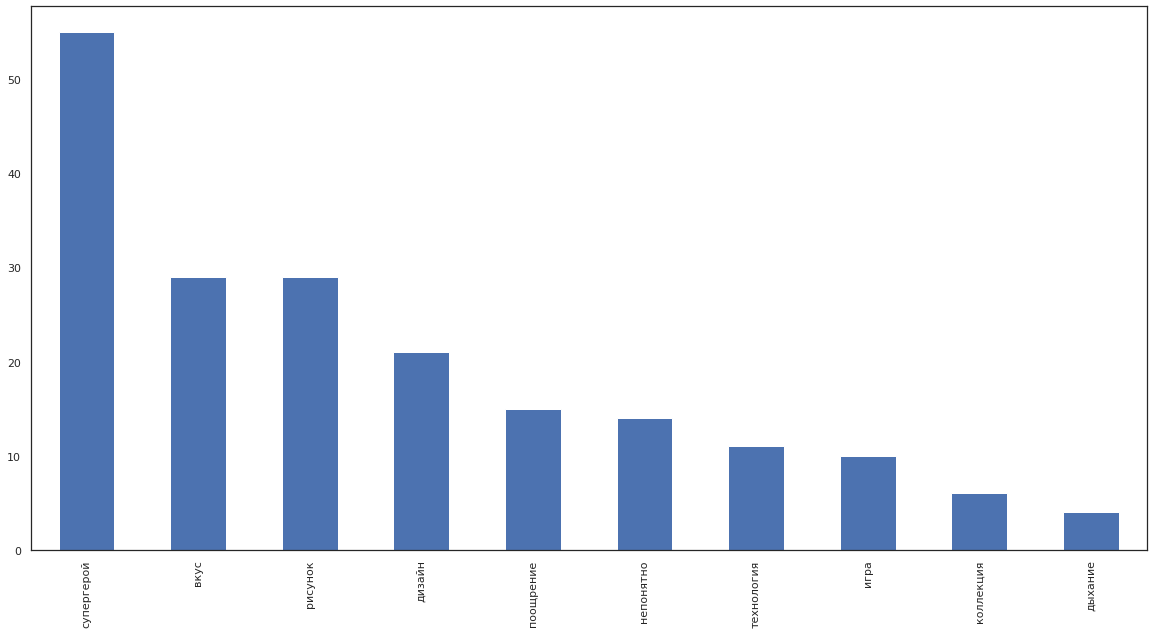

In [186]:
#оценка распределения классов 
plt.figure(figsize=(20,10))
data['class'].value_counts().plot.bar()

Чаще всего оставляют коменты про супергероев. примерно в одной размерности предлагают работать с темами вкус, рисунок и дизайн. Интересно, что именно предлагают сделать со вкусом масок. Можно посмотреть на примеры. 

In [19]:
data[data['class']=='вкус'].sample(5)

,comment,class,text_clean
169,Маска-соска с леденцом,вкус,маска соска леденец
187,чупачупс внутри!,вкус,чупачупс
98,маски со встроенными конфетами без сахара,вкус,маска встроить конфета сахар
11,маски с запахами.,вкус,маска запах
56,Маска с соской,вкус,маска соска


То есть категория вкус больше про всякие запахи для масок. Хорошо хоть облизывать не предлагают. 

Вообще реплик довольно мало выходит, поэтому обучать какие-то модели на них - дохлое дело. Разреженные матрицы получаются неинформативными и кластеры не угадываются. Поэтому для извлечения из слов информации лучше взять предобученные модели для русского языка. Например, пойдет предложенная из фасттекста. 

# Частотный анализ 

Что тут надо сделать: 

1) Сделать список с подготовленными токенами

2) Взглянуть на самые часто встречающиеся 

3) Удалить слова, которые не несут смысловую нагрузку 

4) Визуализировать облако слов

In [257]:
def get_token(series):
  tokens = []
  series.apply(lambda x: tokens.extend(word_tokenize(x)))

  text_clean = nltk.Text(tokens)
  fdist = FreqDist(text_clean)
  print(fdist.most_common(30))

  plt.figure(figsize=(20,10))
  fdist.plot(30,cumulative=False)

In [24]:
from nltk import word_tokenize

In [27]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [54]:
from nltk.probability import FreqDist
fdist = FreqDist(text)

[('маска', 181), ('сделать', 27), ('герой', 27), ('ребёнок', 26), ('который', 23), ('супергерой', 18), ('игра', 14), ('любимый', 13), ('мультик', 11), ('носить', 11), ('разный', 10), ('персонаж', 10), ('запах', 9), ('животное', 8), ('ношение', 8), ('нарисовать', 7), ('придумать', 7), ('весь', 7), ('набор', 6), ('мультфильм', 6), ('цвет', 6), ('рисунок', 6), ('менять', 6), ('нужно', 6), ('показать', 6), ('популярный', 5), ('детский', 5), ('мочь', 5), ('получать', 5), ('каждый', 5)]


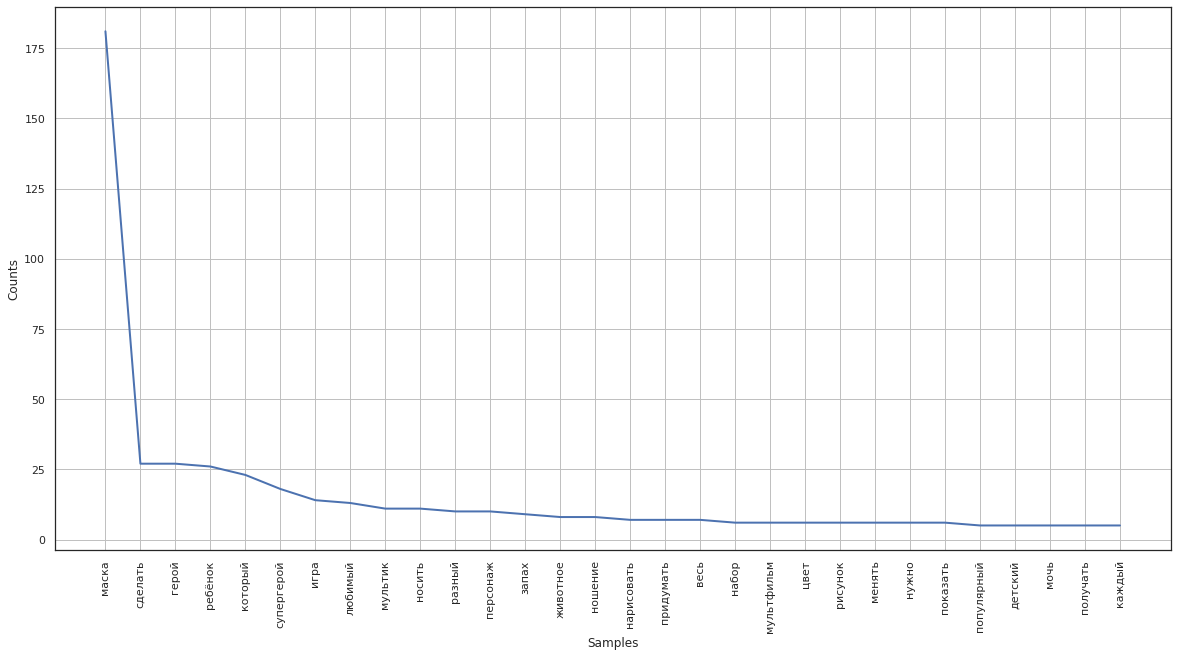

[]


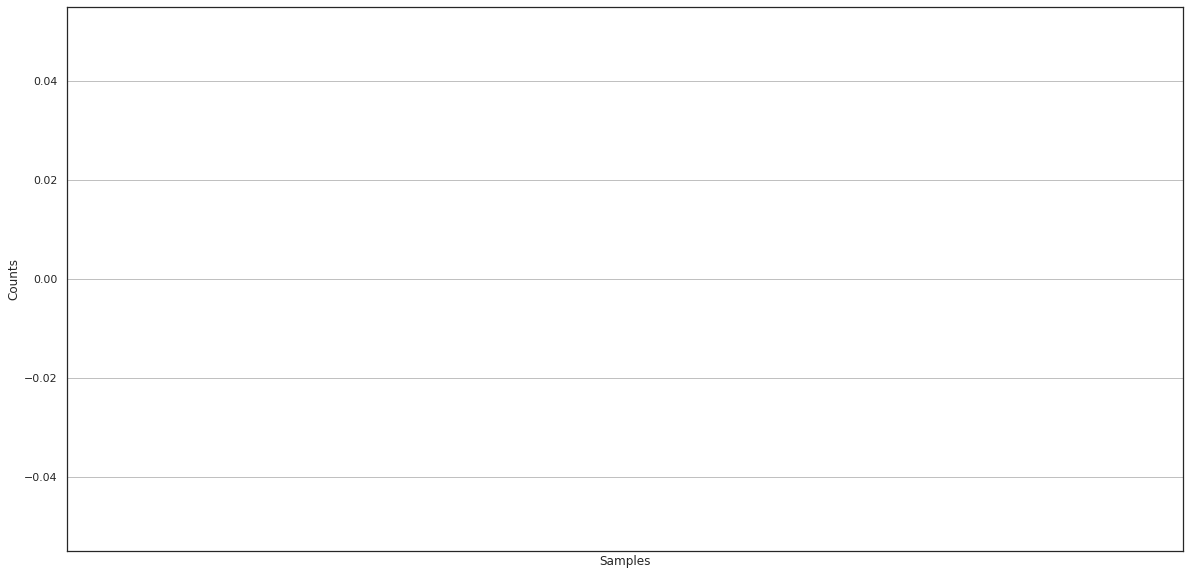

FreqDist()

In [195]:
token_stat(data[['text_clean']])

Сильно выбивается слово маска, вполне возможно, что такой частый интент может служить шумом. 

Можно попробовать убрать из текста само слово маска и объединить похожие слова, типа "герой" и "супергерой". 

In [403]:
data[data['text_clean'].str.contains('время')]

,comment,class,text_clean,vector,test,pred,pred_kmeans
14,"маски с картинками изнутри, которые показывают...",дыхание,картинка изнутри показываться подышать время,"[-0.009959394, -0.026898317, 0.019869424, 0.07...",NaN,-1,4
147,сделать маску которая бы меняла рисунок в зави...,рисунок,менять рисунок зависимость время сутки,"[0.011475404, -0.0589895, 0.041767962, 0.04116...",NaN,-1,8
181,"маски, меняющие вид спустя сколько-то времени ...",технология,менять вид сколько время,"[0.019454956, -0.08307636, 0.07018781, 0.13628...",NaN,-1,3


In [404]:
def best_text(text):
    text = re.sub(r'маска','', text)
    text = re.sub('[^а-яА-Я ]', '', text)
    text = re.sub('который', '', text)
    text = re.sub('супергерой', 'герой', text)
    text = re.sub('ребнок', '', text)
    text = re.sub('любимый', '', text)
    text = re.sub('разный', '', text)
    text = re.sub('ношение', '', text)
    text = re.sub('придумать', '', text)
    text = re.sub('весь', '', text)
    text = re.sub('набор', '', text)
    text = re.sub('цвет', 'рисунок', text)
    text = re.sub('нужно', '', text)
    text = re.sub('мочь', '', text)
    text = re.sub('каждый', '', text)
    text = re.sub('надеть', '', text)
    text = re.sub('носить', '', text)
    text = re.sub('показать', '', text)
    text = re.sub('популярный', '', text)
    text = re.sub('детский', '', text)
    text = re.sub('день', '', text)
    text = re.sub('нос', '', text)
    text = re.sub('сделать', '', text)
    text = re.sub('мультфильм', 'мультик', text)
    text = re.sub('нарисовать', 'рисовать', text)
    text = re.sub('задание', '', text)
    text = re.sub('эмоция', '', text)
    text = re.sub('мульт', 'мультик', text)
    text = re.sub('твой', '', text)
    text = re.sub('маленький', '', text)
    text = re.sub('тд', '', text)
    text = re.sub('время', '', text)





    return text 
    

In [405]:
data['text_clean'] = data['text_clean'].apply(lambda x: best_text(x))

[('герой', 45), ('мультикикик', 17), ('игра', 14), ('рисунок', 12), ('рисовать', 11), ('персонаж', 10), ('запах', 9), ('животное', 8), ('менять', 6), ('получать', 5), ('вкус', 5), ('соска', 5), ('съедобный', 4), ('друг', 4), ('играть', 4), ('настроение', 4), ('балл', 4), ('мультикик', 4), ('часть', 4), ('конфета', 4), ('лицо', 4), ('встроить', 4), ('вид', 4), ('принтами', 3), ('конфетка', 3), ('должный', 3), ('коллекция', 3), ('изнутри', 3), ('леденец', 3), ('надевать', 3)]


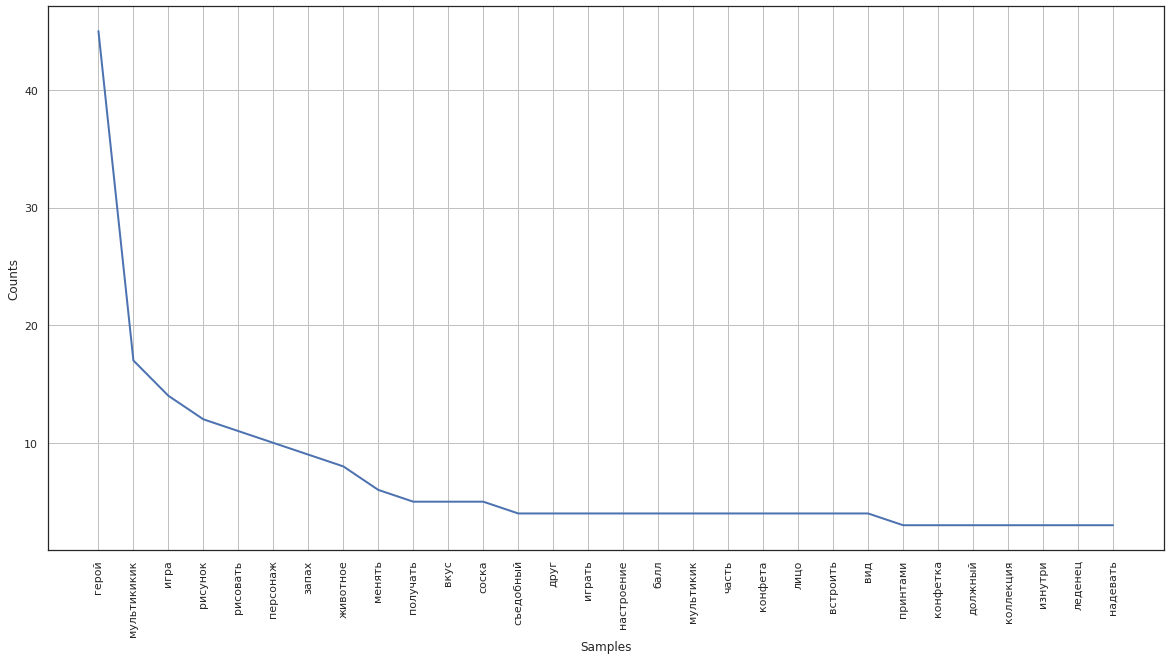

[]


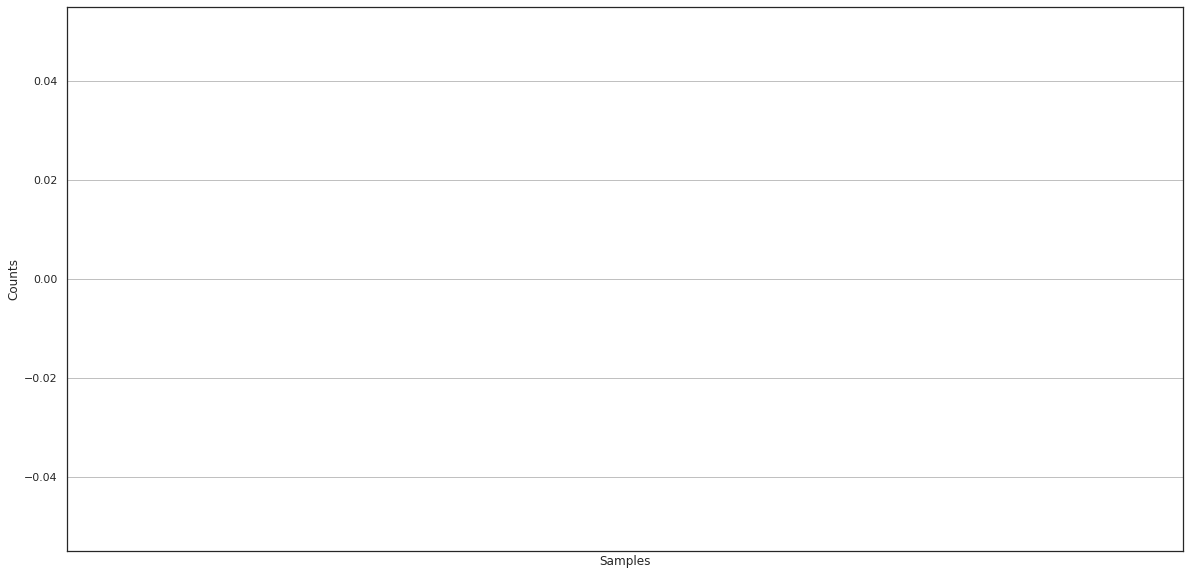

FreqDist()

In [406]:
token_stat(data[['text_clean']])

# Кластеризация

Сначала можно взглянуть на расстояние между элементами

In [341]:
data['vector'] = data['text_clean'].map(get_sentence_vector)

In [342]:
#перебор параметров для knn 
knn_params = {'n_neighbors': range(1, 10)}
knn = KNeighborsClassifier(weights='distance')
knn_grid = GridSearchCV(knn, knn_params,
cv=5, n_jobs=-1,
verbose=True)

In [343]:
#вертикальное объединение массивов в 1 большой массив 
vectors = np.vstack(data['vector'].values) 
knn_grid.fit(vectors, np.zeros(len(data)))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='distance'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': range(1, 10)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=True)

In [306]:
knn_grid.best_params_

{'n_neighbors': 1}

In [307]:
knn = KNeighborsClassifier(weights='distance', n_neighbors=1)
knn.fit(vectors, np.zeros(len(data)))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='distance')

In [308]:
query_index = 0
query_label = data['class'].iloc[query_index]

In [309]:
#возвращает дистанцию до n ближайших соседей и индексы точек
distances, indexes = knn.kneighbors(vectors[[query_index]], n_neighbors=len(data))

In [310]:
#сколько раз встречается тестовый класс "супергерой"
support = (data['class'] == query_label).sum()

In [311]:
#55 ближайших соседей 
top_predictions = data['class'].iloc[indexes[0][:support]]

In [312]:
print('Accuracy по в классу для этого предложения:', (top_predictions == query_label).mean())


Accuracy по в классу для этого предложения: 0.7636363636363637


In [313]:
# на размеченных данных получилось около 10 классов, в идеале и кластеров должно быть примерно столько же 
data['class'].nunique()

10

In [314]:
print('Расстояние\tНормализированный текст')
for i, d  in zip(indexes[0], distances[0]):
    print(round(d, 2), data['class'].iloc[i], data['text_clean'].iloc[i], sep='\t')

Расстояние	Нормализированный текст
0.0	супергерой	сделать  изображение популярный герой массовый культура
0.61	супергерой	создать уникальный  любимый детский герой
0.62	супергерой	 должный составлять коллекция изображать герой современный мультфильм
0.63	супергерой	сделать  принтами животное герой любимый герой мультик
0.64	супергерой	 нарисовать известный детский герой
0.64	супергерой	нужно мультфильм добавить герой  сделпть модный
0.65	супергерой	 нарисовать любимый герой
0.65	супергерой	мультик главный герой начать носить 
0.66	супергерой	сделать  часть костюм герой
0.67	супергерой	герой мультик герой начать носить 
0.68	супергерой	 изображение любимый герой смешарик
0.68	супергерой	известный герой
0.68	рисунок	сделать  рисунок любимый персонаж
0.68	супергерой	интересный  мульт герой завлекать малыш самый носить
0.68	супергерой	 животное любимый герой
0.69	супергерой	целое любой контент  потреблять активно  нужно внедрить главный герой 
0.7	супергерой	 любимый герой
0.7	супергерой	п

In [315]:
result ={}
for eps in np.arange(0.1, 1, 0.005):
    clustering = DBSCAN(eps=eps, min_samples=3).fit(vectors)
    result[eps]= len(set(clustering.labels_))

In [316]:
max(result.values())

9

In [317]:
#расстояние для лучшего срабатывания DBSCAN
[dist for dist, n in result.items() if n == 8]

[0.6250000000000004,
 0.6300000000000004,
 0.6350000000000005,
 0.6400000000000005,
 0.6450000000000005,
 0.6600000000000005,
 0.6900000000000005]

In [318]:
clustering = DBSCAN(eps=0.5200000000000004, min_samples=3).fit(vectors)

In [319]:
clustering.labels_

array([-1, -1,  0, -1,  0, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,
       -1, -1,  1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  0,
       -1,  1,  0,  0, -1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  0,  0, -1,  0, -1, -1, -1, -1, -1, -1,  2, -1, -1,  0, -1,
        0, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  2, -1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1,  0,
       -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,  0, -1, -1, -1,  1, -1,  2,
       -1, -1, -1, -1, -1, -1,  1,  2, -1,  0, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  0, -1, -1, -1, -1])

In [320]:
data['pred'] = clustering.labels_

## Визуализация

In [321]:
tsne = TSNE()
xy = tsne.fit_transform(vectors)

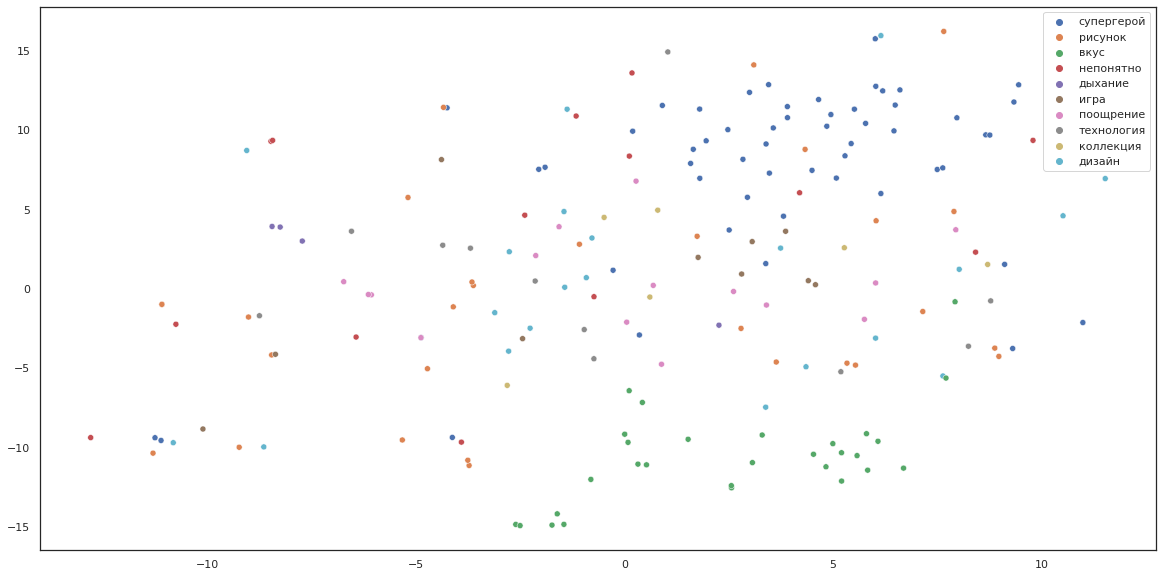

In [324]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=xy[:,0], y=xy[:,1], hue=data['class'].values)

In [354]:
v_measure_score(data['class'], data['pred'])

0.2056825932876692

In [355]:
y = data['class']

кластеров - 1, метрика - 1.7541242171112808e-16
кластеров - 2, метрика - 0.30051381293802876
кластеров - 3, метрика - 0.37872359410706935
кластеров - 4, метрика - 0.3720154510842667
кластеров - 5, метрика - 0.3676418352675982
кластеров - 6, метрика - 0.39603037701034033
кластеров - 7, метрика - 0.38316392837896074
кластеров - 8, метрика - 0.34110084314775024
кластеров - 9, метрика - 0.39578137006861397
кластеров - 10, метрика - 0.4121175241672102
кластеров - 11, метрика - 0.40740990722307946


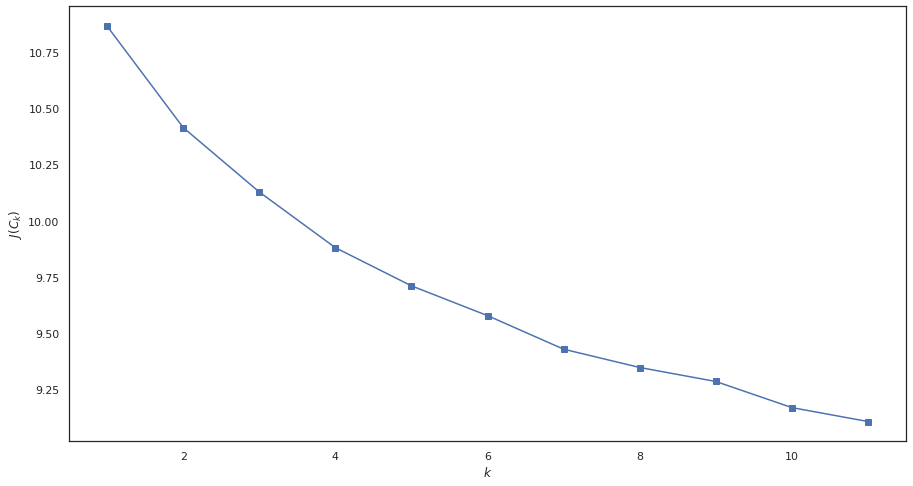

In [407]:
inertia = []
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(vectors)
    inertia.append(np.sqrt(kmeans.inertia_))
    result = v_measure_score(y, kmeans.predict(vectors))
    print(f'кластеров - {k}, метрика - {result}')

plt.figure(figsize = (15,8))
plt.plot(range(1, 12), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

А вот если смотреть на алгоритм k-means, то результат сильно лучше получается, особенно при 10 кластерах. 

In [357]:
kmeans = KMeans(n_clusters=10, random_state=1).fit(vectors)

In [358]:
kmeans.labels_

array([1, 3, 1, 0, 1, 1, 2, 4, 6, 4, 9, 5, 2, 1, 4, 4, 0, 8, 1, 8, 1, 1,
       8, 8, 8, 3, 8, 8, 1, 2, 4, 6, 4, 1, 8, 8, 5, 1, 4, 0, 8, 1, 4, 2,
       4, 1, 0, 5, 1, 1, 1, 6, 5, 1, 1, 4, 7, 5, 4, 8, 2, 0, 8, 0, 8, 5,
       8, 2, 4, 8, 8, 6, 5, 4, 8, 8, 1, 4, 2, 4, 0, 8, 4, 0, 0, 8, 0, 1,
       1, 8, 1, 0, 1, 0, 0, 8, 9, 7, 2, 1, 1, 8, 1, 4, 4, 0, 8, 1, 8, 1,
       5, 2, 8, 7, 4, 3, 5, 0, 3, 8, 0, 8, 3, 0, 8, 8, 0, 8, 3, 3, 8, 0,
       1, 5, 9, 9, 1, 8, 3, 6, 1, 9, 6, 1, 1, 8, 8, 8, 8, 1, 8, 0, 1, 8,
       0, 1, 0, 1, 8, 8, 8, 8, 8, 1, 2, 6, 4, 5, 8, 7, 1, 8, 3, 5, 4, 4,
       5, 7, 5, 1, 0, 3, 4, 8, 0, 1, 1, 2, 6, 1, 2, 8, 4, 8], dtype=int32)

In [408]:
data['pred_kmeans'] = kmeans.labels_

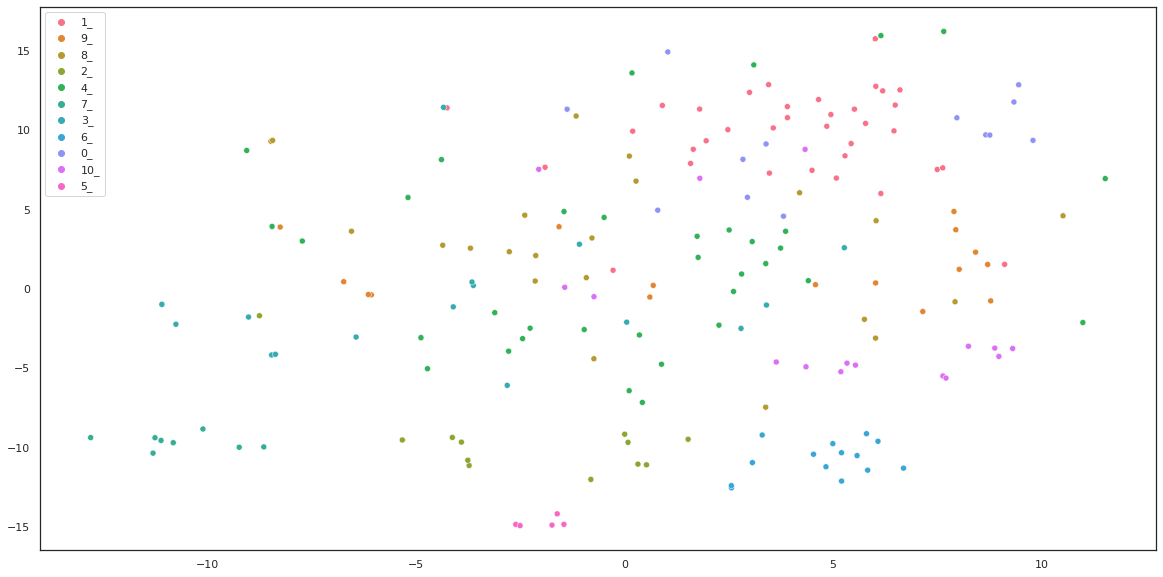

In [409]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=xy[:,0], y=xy[:,1], hue=data['pred_kmeans'].map(lambda x: str(x) + '_').values)

На K-means действительно получается лучше кластеризовать этот текст. 
Особенно хорошо это прослеживается на данных, прогнанных через PCA.

In [410]:
agglo1 = AgglomerativeClustering(n_clusters = 10, affinity='euclidean')

In [411]:
agglo1.fit(vectors)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=10)

In [412]:
agglo1.labels_

array([4, 5, 4, 5, 4, 4, 0, 6, 9, 6, 3, 8, 0, 4, 5, 5, 2, 5, 4, 5, 4, 4,
       1, 5, 1, 3, 3, 5, 1, 0, 6, 9, 6, 2, 5, 5, 8, 4, 2, 2, 5, 4, 0, 0,
       6, 4, 9, 8, 1, 2, 4, 9, 8, 2, 4, 2, 7, 0, 6, 5, 0, 2, 5, 0, 1, 0,
       5, 0, 5, 0, 5, 9, 0, 5, 5, 5, 2, 2, 0, 6, 5, 5, 2, 5, 2, 1, 4, 4,
       4, 5, 4, 2, 4, 0, 2, 0, 0, 7, 0, 4, 4, 5, 4, 5, 5, 2, 5, 2, 3, 3,
       8, 0, 1, 7, 5, 1, 8, 5, 1, 5, 5, 5, 5, 2, 5, 5, 2, 5, 1, 1, 5, 5,
       4, 8, 3, 3, 4, 5, 1, 9, 4, 3, 9, 4, 5, 5, 1, 5, 1, 4, 5, 5, 4, 5,
       5, 4, 2, 4, 5, 5, 5, 5, 4, 4, 0, 9, 5, 8, 5, 7, 4, 5, 1, 8, 6, 5,
       8, 7, 8, 4, 3, 1, 5, 1, 2, 4, 5, 0, 9, 4, 0, 5, 6, 5])

In [413]:
v_measure_score(y, agglo1.labels_)

0.3908143134435158

# Проба другой предобученной модели


In [414]:
!pip3 install wget

In [415]:
!pip3 install gensim

In [416]:

model_url = 'http://vectors.nlpl.eu/repository/20/65.zip'
m = wget.download(model_url)
model_file = model_url.split('/')[-1]
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

In [417]:
def get_sentence_vector_second(sentence):
    vec = np.zeros_like(model.word_vec('привет'))
    sentence_split = sentence.split() 
    for word in sentence.split():
      try:
        vec += model.word_vec(word)
      except:
        continue
#     return vec / len(sentence_split)
    return vec / np.linalg.norm(vec)

In [418]:
data['vector_second'] = data['text_clean'].map(get_sentence_vector_second)

In [419]:
second_vectors =  np.vstack(data['vector_second'].values) 

In [420]:
kmeans = KMeans(n_clusters=10, random_state=1).fit(second_vectors)

In [421]:
v_measure_score(data['class'], kmeans.labels_)

0.45269490285399927

In [422]:
data['s_k_pred'] = kmeans.labels_

In [423]:
tsne = TSNE()
xy = tsne.fit_transform(second_vectors)

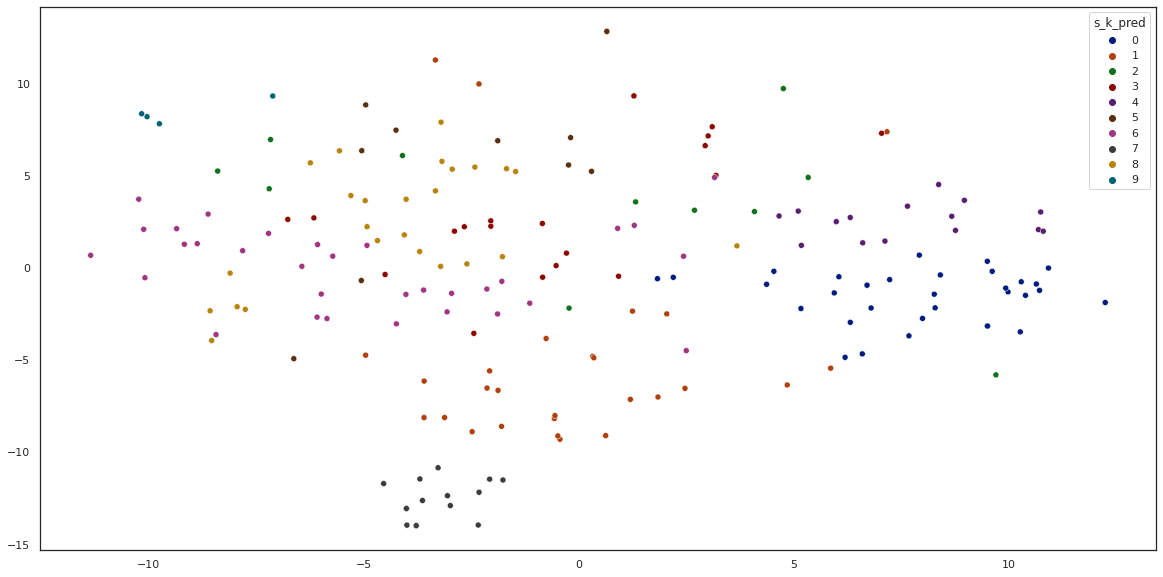

In [424]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=xy[:,0], y=xy[:,1], hue=data['s_k_pred'], palette = 'dark')

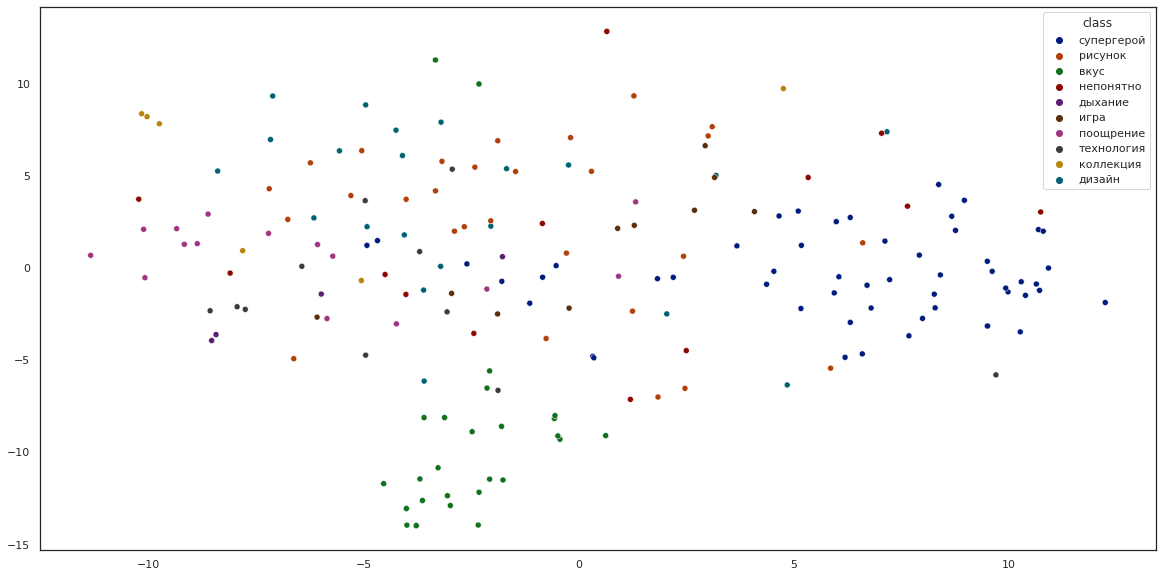

In [427]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=xy[:,0], y=xy[:,1], hue=data['class'], palette = 'dark')